In [2]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

In [15]:
# Create a dictionary to store discharge cycles with info about the discharge_capacity and csv file name for certain battery
batteries_discharge_cycles = {
    'B0005': {'discharge_capacity': [], 'csv_file': []},
    'B0006': {'discharge_capacity': [], 'csv_file': []},
    'B0007': {'discharge_capacity': [], 'csv_file': []},
    'B0018': {'discharge_capacity': [], 'csv_file': []},
}

# Read and store metadata information for analyzed batteries
metadata = pd.read_csv('cleaned_dataset/metadata.csv')

# Iterate over each row in the metadata dataframe
for index, row in metadata.iterrows():
    battery_id = row['battery_id']
    data_type = row['type']
    filename = row['filename']
    discharge_capacity = row['Capacity']

    # Check if the battery ID exists in the batteries dictionary
    if battery_id in batteries_discharge_cycles:
        # Check the data type and save the file to the appropriate subdirectory
        if data_type == 'discharge':
            batteries_discharge_cycles[battery_id]['csv_file'].append(filename)
            batteries_discharge_cycles[battery_id]['discharge_capacity'].append(discharge_capacity)

for key, value in batteries_discharge_cycles.items():
    print(key, value)


B0005 {'discharge_capacity': ['1.8564874208181574', '1.846327249719927', '1.8353491942234077', '1.8352625275821128', '1.8346455082120419', '1.8356616600675495', '1.8351461429226603', '1.8257567905665537', '1.8247738529891333', '1.824613268496936', '1.8246195526864504', '1.8142019357673917', '1.8137521577549054', '1.8134404914735822', '1.8025980036306504', '1.80210690024615', '1.802579500826209', '1.8030683142834096', '1.8027776247196041', '1.8470259949329193', '1.847417311283644', '1.8361774213478947', '1.8257807475776242', '1.8251136435078368', '1.8255815042203762', '1.8140311275083907', '1.8147691941158939', '1.813969388710352', '1.802765665167823', '1.804077040117352', '1.8518025516704486', '1.8307038456739428', '1.8199041089501267', '1.8093079637028517', '1.80460990458052', '1.7993770651972192', '1.7884432335370462', '1.7829230484252723', '1.7730337158018288', '1.773037755078937', '1.7678721106662054', '1.7623150704093087', '1.7676172924938447', '1.762668359743147', '1.751730487066

In [3]:
DISCHARGE_PATH = 'analyzed_dataset/B0005/discharge/'
# Load first file in discharge directory
df = pd.read_csv(DISCHARGE_PATH + '05122.csv')
df.head()


,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922


# Prior predictive checks

Below assumaptions were made for prior predictive checks:
- Rated capacity of lithium-ion battery is 2.0 Ah (according to the dataset description)
- Fully discharged voltage is 2.7 V (according to the dataset description)
- SoH and SoC are equal to 100% since the battery is new and fully charged
- Time and current measurements are affected by measurement errors
- Discharge capacity may differ from rated capacity

In [4]:
# Compile Stan model
model_ppc = CmdStanModel(stan_file='stan/battery_ppc.stan')
model_ppc.compile(force=True)


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiling stan file /usr/battery-pack-model-and-data/stan/battery_ppc.stan to exe file /usr/battery-pack-model-and-data/stan/battery_ppc
INFO:cmdstanpy:compiled model executable: /usr/battery-pack-model-and-data/stan/battery_ppc


In [5]:
# Load input data from the first file
current_measured = df['Current_measured'].values
time_measured = df['Time'].values

# Assume below parameters
rated_capacity = 2.0    # Ah
initial_soc = 1         # 100%
initial_soh = 1         # 100%
fully_discharged_voltage = 2.7 # V

# Data dictionary
data_sim = {
    'N': len(time_measured),
    'current_measured': current_measured,
    'time_measured': time_measured,
    'rated_capacity': rated_capacity,
    'initial_soc': initial_soc,
    'initial_soh': initial_soh,
}

In [6]:
# Sample from prior predictive check
R = 100
sim = model_ppc.sample(data=data_sim,
                       fixed_param=True,
                       iter_sampling=R,
                       iter_warmup=0,
                       seed=1)
                       
df_sim = sim.draws_pd()
df_sim.head()


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,prior_capacity,time_step[1],time_step[2],time_step[3],time_step[4],time_step[5],time_step[6],time_step[7],...,estimated_discharge[188],estimated_discharge[189],estimated_discharge[190],estimated_discharge[191],estimated_discharge[192],estimated_discharge[193],estimated_discharge[194],estimated_discharge[195],estimated_discharge[196],estimated_discharge[197]
0,0.0,0.0,2.02050,0.0,16.5248,18.7086,18.7285,18.6234,17.3473,19.0952,...,1.86182,1.86184,1.86184,1.86184,1.86186,1.86187,1.86188,1.86188,1.86188,1.86192
1,0.0,0.0,2.17692,0.0,16.3469,19.6630,17.4324,18.6652,17.2571,18.5047,...,1.86315,1.86317,1.86317,1.86318,1.86319,1.86320,1.86321,1.86321,1.86321,1.86325
2,0.0,0.0,1.78178,0.0,17.0460,18.8842,17.9094,17.5219,18.8418,17.6959,...,1.85984,1.85986,1.85986,1.85987,1.85988,1.85989,1.85990,1.85990,1.85990,1.85994
3,0.0,0.0,1.81586,0.0,16.6559,18.3528,18.5312,18.6857,18.8476,16.7372,...,1.86093,1.86095,1.86095,1.86096,1.86097,1.86098,1.86099,1.86099,1.86099,1.86103
4,0.0,0.0,2.01478,0.0,16.5841,18.9623,17.8712,17.8737,18.7409,18.1586,...,1.86139,1.86141,1.86141,1.86141,1.86143,1.86144,1.86144,1.86145,1.86145,1.86149


In [7]:
# Find discharge mode start and end index

# Begining of the constant discharge mode is for first measured current above 0.01
first_discharge_mode_idx = np.where(np.abs(current_measured) > 0.01)[0][0]
print('First discharge mode index: ', first_discharge_mode_idx)

# End of the constant discharge mode is for last measured current above 0.01
last_discharge_mode_idx = np.where(np.abs(current_measured) > 0.01)[0][-1]
print('Last discharge mode index: ', last_discharge_mode_idx)

# Save end and begining of open circuit voltage mode
ocv_mode_end_idx = first_discharge_mode_idx - 1
ocv_mode_start_idx = last_discharge_mode_idx + 1

First discharge mode index:  2
Last discharge mode index:  179


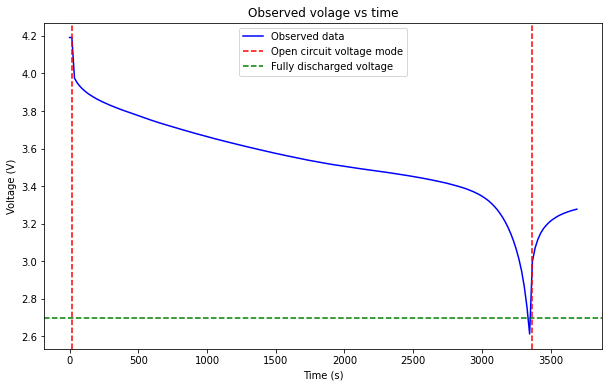

In [8]:
# Plot on chart observed voltage vs time
# axis x shows time, axis y shows voltage
plt.figure(figsize=(10, 6))
plt.title('Observed volage vs time')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.plot(time_measured, df['Voltage_measured'].values, label='Observed data', color='blue')
# mark lines of open circuit voltage mode
plt.axvline(x=time_measured[ocv_mode_end_idx], color='red', linestyle='--', label='Open circuit voltage mode')
plt.axvline(x=time_measured[ocv_mode_start_idx], color='red', linestyle='--')
# mark line of fully discharged voltage
plt.axhline(y=fully_discharged_voltage, color='green', linestyle='--', label='Fully discharged voltage')
plt.legend()
plt.show()

In [11]:
# Extract the estimated_soc values into separate numpy arrays for each index
estimated_soc = np.zeros((R, len(time_measured)))
final_estimated_soc = np.zeros(R)
estimated_discharge = np.zeros((R, len(time_measured)))
final_estimated_discharge_capacity = np.zeros(R)
for i in range(R):
    for j in range(len(time_measured)):
        estimated_soc[i, j] = df_sim['estimated_soc[{}]'.format(j+1)][i] * 100
        estimated_discharge[i, j] = df_sim['estimated_discharge[{}]'.format(j+1)][i]
    final_estimated_soc[i] = df_sim['estimated_soc[{}]'.format(len(time_measured))][i] * 100
    final_estimated_discharge_capacity[i] = df_sim['estimated_discharge[{}]'.format(len(time_measured))][i]


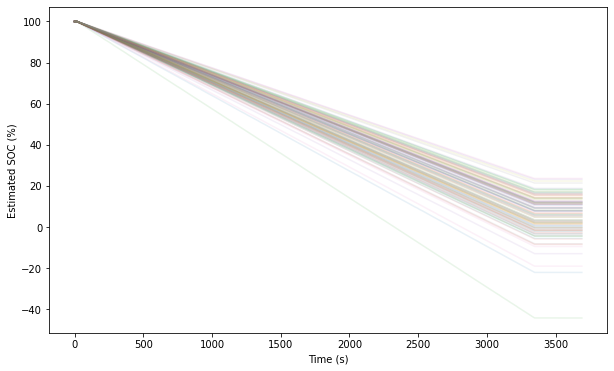

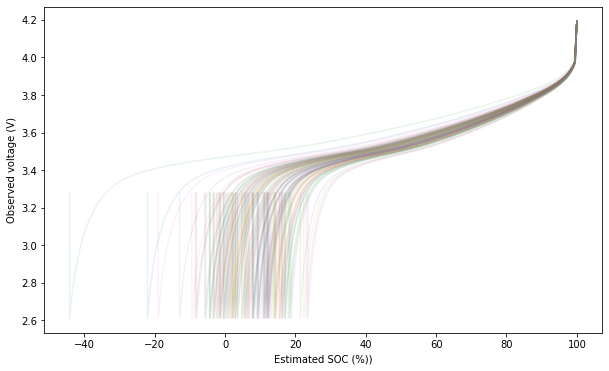

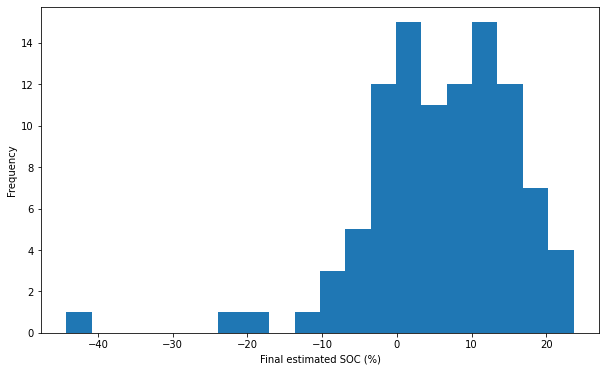

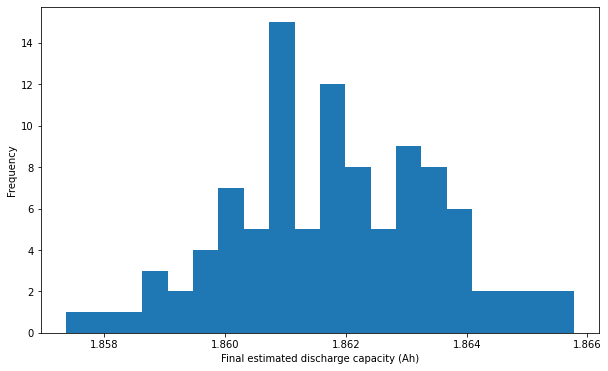

In [12]:

# Plot the estimated_soc values vs time
plt.figure(figsize=(10, 6))
for i in range(R):
    plt.plot(time_measured, estimated_soc[i, :], alpha=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Estimated SOC (%)')
plt.show()

# Plot the estiamted_soc values vs observed voltage
plt.figure(figsize=(10, 6))
for i in range(R):
    plt.plot(estimated_soc[i, :], df['Voltage_measured'].values, alpha=0.1)
plt.xlabel('Estimated SOC (%)')
plt.ylabel('Observed voltage (V)')
plt.show()

# Plot the histogram of the final estimated_soc values
plt.figure(figsize=(10, 6))
plt.hist(final_estimated_soc, bins=20)
plt.xlabel('Final estimated SOC (%)')
plt.ylabel('Frequency')
plt.show()

# Plot the histogram of the final estimated_discharge_capacity values
plt.figure(figsize=(10, 6))
plt.hist(final_estimated_discharge_capacity, bins=20)
plt.xlabel('Final estimated discharge capacity (Ah)')
plt.ylabel('Frequency')
plt.show()

Text(0, 0.5, 'Final estimated discharge capacity (Ah)')

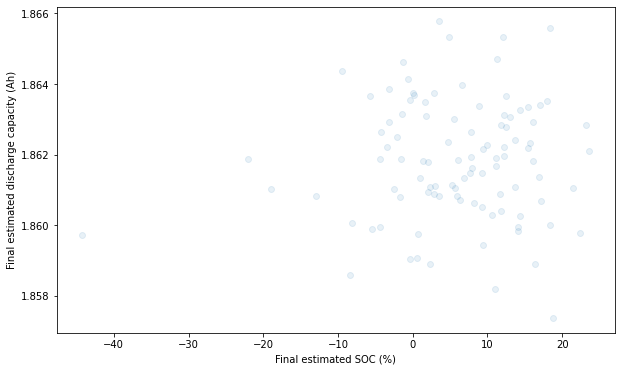

In [13]:
# Plot joint distribution of final estimated_soc and final estimated_discharge_capacity
plt.figure(figsize=(10, 6))
plt.scatter(final_estimated_soc, final_estimated_discharge_capacity, alpha=0.1)
plt.xlabel('Final estimated SOC (%)')
plt.ylabel('Final estimated discharge capacity (Ah)')